In [12]:
import os 

import numpy as np 
import pandas as pd 

from scipy.stats.mstats import mquantiles
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.figsize"] = (6,4)
rcParams["figure.dpi"] = 150

from classy import Class

import getdist
from getdist import plots, MCSamples

In [2]:
from utils import Data, AbstractModel, Sampler, cosmo

%load_ext autoreload
%autoreload 2

Read the data file

In [3]:
fname = os.path.join(".", "data", "lyman-alpha.txt")
data = pd.read_csv(fname, delimiter=" ", skiprows=1 , names=["k", "P_k", "error"])

In [4]:
data.head()

,k,P_k,error
0,0.207742,803.702776,263.217567
1,0.336243,321.939774,81.810216
2,0.464745,246.267694,49.818357
3,0.593246,119.664030,18.970907
4,0.721747,50.380598,9.173003


In [5]:
k, P_k, P_k_error = data[["k", "P_k", "error"]].T.values

# Data

In [6]:
data = Data(k,P_k,P_k_error,cosmo)

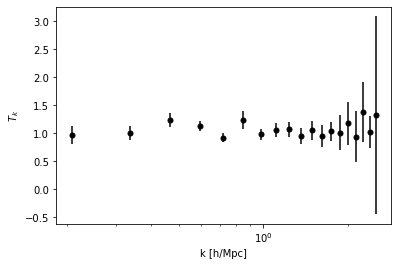

In [7]:
data.plot_Tk(color="k")

## Alpha Beta Gamma Model

In [8]:
def Murgia18_Tk(k, alpha, beta, gamma):
        """# Eq. 4 in Murgia+2018"""
        
        return (1+(alpha*k)**beta)**gamma
    

In [9]:
class MurgiaModel(AbstractModel):
    
    def get_T_k(self, model_params):
        """# Eq. 4 in Murgia+2018"""
            
        return Murgia18_Tk(self.k, model_params["alpha"], model_params["beta"], model_params["gamma"])
        

In [10]:
model_params = {"alpha": 0.1,
                "beta": 1,
                "gamma": -1}

murgia_model = MurgiaModel(data.k, model_params, cosmology=cosmo)

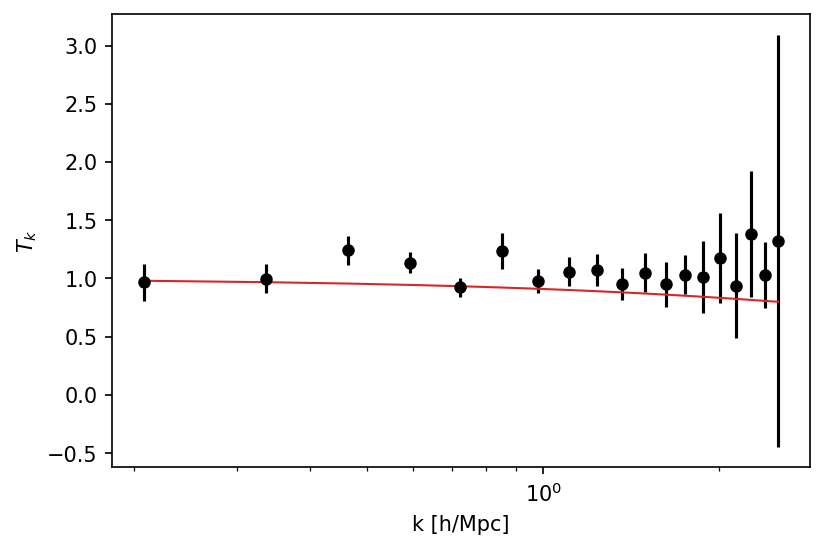

In [13]:
murgia_model.plot_Tk()
data.plot_Tk()

### Posterior Sampling

In [91]:
posterior = Sampler(data, murgia_model, 
                    param_names=["alpha", "beta", "gamma"], 
                    param_limits=[[0,1], [0,10], [-10,1]],
                    n_walkers=50,
                    n_steps=100000,
                   )

In [92]:
posterior.sample(find_lkl_min=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

initializing the sampler...


/Users/siavashyasini/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100000/100000 [03:08<00:00, 531.63it/s]


### Plots

Removed no burn in


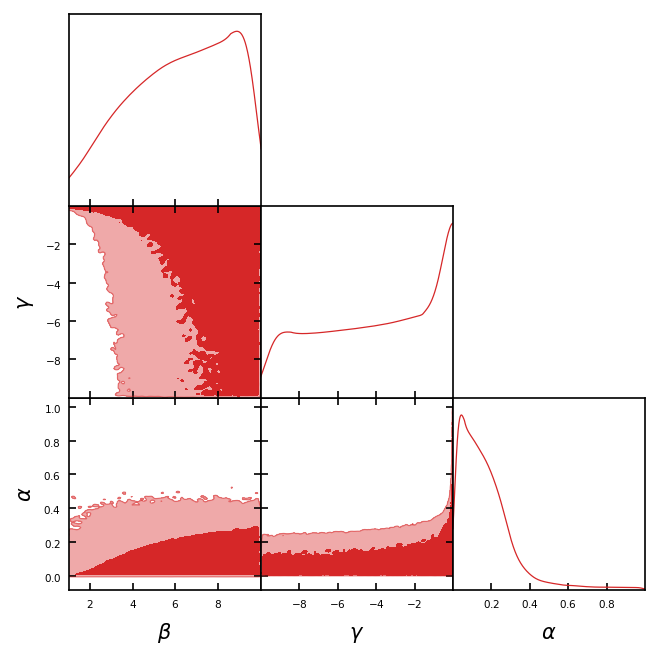

In [97]:
# roll the last axis backwards by 1 to match the parameter order with Murgia+18
burn_in = 10000
samples = MCSamples(samples=np.roll(posterior.samples[burn_in:,:,:],-1,axis=-1), 
                    names=[r"$\beta$", r"$\gamma$",r"$\alpha$"])

g = plots.getSubplotPlotter(subplot_size=1.5)

g.settings.lw_contour = 1.
g.settings.legend_fontsize = 14
g.settings.lab_fontsize = 14
g.settings.axes_fontsize = 9

g.triangle_plot(samples, 
                filled = True,
                contour_colors=["tab:red"],
                param_limits={r"$\beta$":[1,10],
                              r"$\gamma$":[-10,0],
                              r"$\alpha$":[0,1]} )

#plt.savefig("alpha_beta_gamma_posterior.png", dpi=200, bbox_inches="tight")


/Users/siavashyasini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


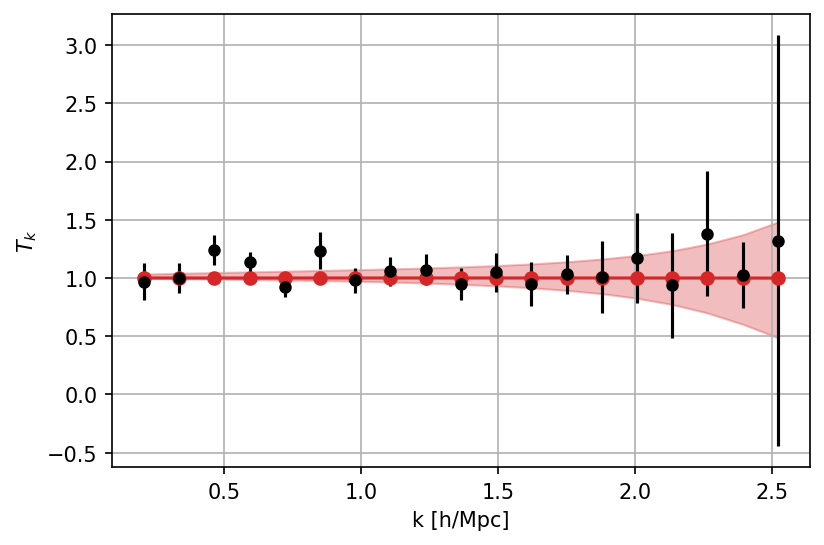

In [98]:
T_k_samples = Murgia18_Tk(data.k[:,None], *posterior.samples.reshape(-1,3).T)[:,burn_in:]
T_k_mean = np.median(T_k_samples, axis=1)
T_k_quantiles = mquantiles(T_k_samples, [0.003, 0.997], axis=1)

plt.plot(data.k, T_k_mean, "-o", color="tab:red")
data.plot_Tk()
plt.fill_between(data.k, T_k_quantiles[:,0], T_k_quantiles[:,1], alpha=0.3, color="tab:red")    

plt.grid()
plt.xscale("linear")

## Exponential Model (test case)

In [24]:
def exponential(k, k0, alpha, gamma):
    return 1+alpha*np.exp(-(k-k0)*gamma)

In [25]:
class ExponentialModel(AbstractModel):
    
    def get_T_k(self, model_params):

        return exponential(self.k, model_params["k0"], model_params["alpha"], model_params["gamma"])
    

In [59]:
model_params = {"alpha": -0.2,
                "k0": 2,
                "gamma": -2} #gamma is always negative 

exp_model = ExponentialModel(data.k, model_params, cosmology=cosmo)


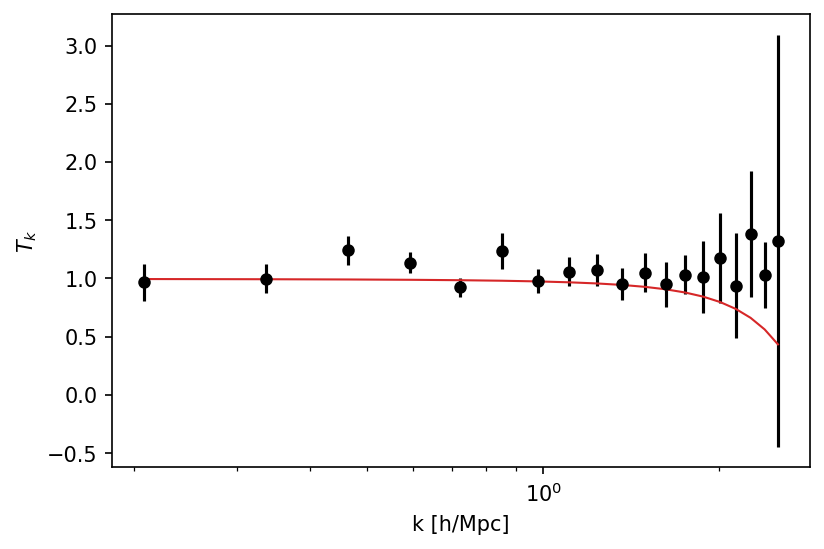

In [60]:
exp_model.plot_Tk()
data.plot_Tk()

### Posterior Sampling

In [99]:
posterior = Sampler(data, exp_model, 
                    param_names=["alpha", "k0", "gamma"], 
                    param_limits=[[-1,1], [0.,5], [-10,0]],
                    guess=[0,0,0],
                    n_walkers=50,
                    n_steps=100000,
                   )

In [100]:
posterior.sample(find_lkl_min=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

initializing the sampler...


/Users/siavashyasini/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100000/100000 [02:55<00:00, 568.30it/s]


### Plots

Removed no burn in


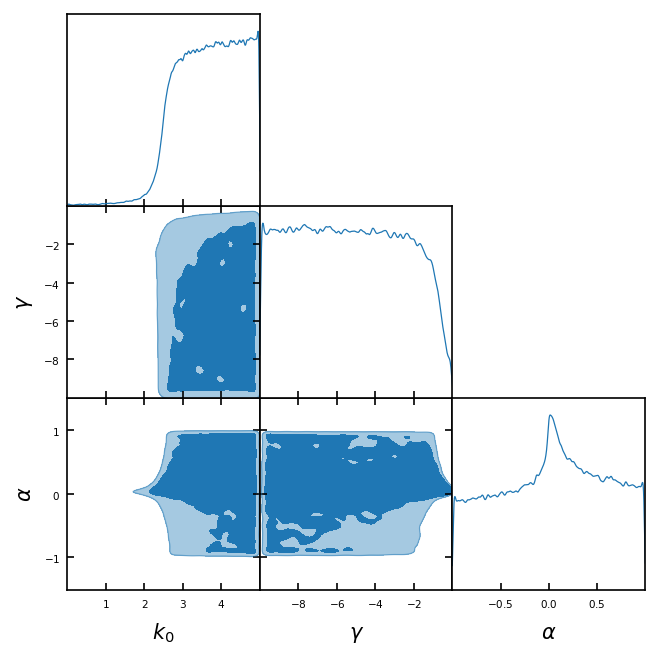

In [105]:
# roll the last axis backwards by 1 to match the parameter order with Murgia+18
burn_in = 10000
samples = MCSamples(samples=np.roll(posterior.samples[burn_in::10,:,:],-1,axis=-1), 
                    names=[r"$k_0$", r"$\gamma$",r"$\alpha$"])

g = plots.getSubplotPlotter(subplot_size=1.5)

g.settings.lw_contour = 1.
g.settings.legend_fontsize = 14
g.settings.lab_fontsize = 14
g.settings.axes_fontsize = 9

g.triangle_plot(samples, 
                filled = True,
                contour_colors=["tab:blue"],
                param_limits={r"$k_0$":[0.0,5],
                              r"$\gamma$":[-10,0],
                              r"$\alpha$":[-1.,1.]} )


#plt.savefig("alpha_beta_gamma_posterior.png", dpi=200, bbox_inches="tight")


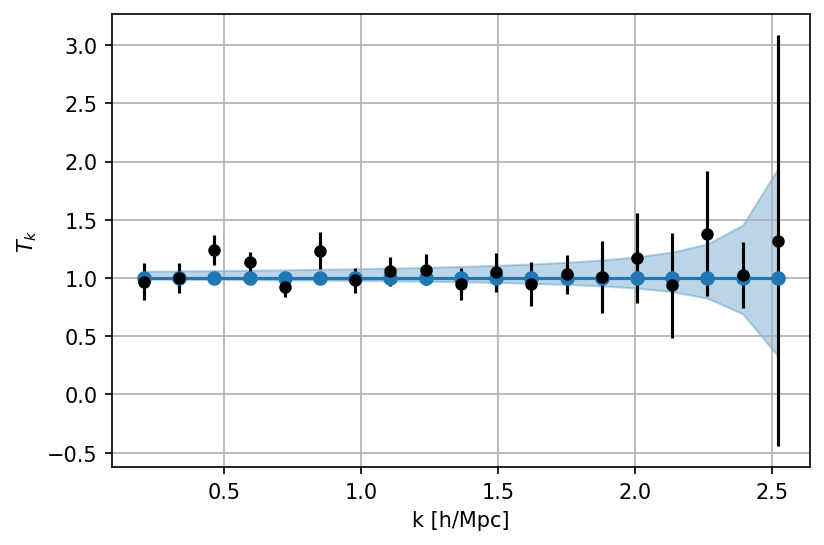

In [106]:
alpha, k_0, gamma = posterior.samples.reshape(-1,3).T
T_k_samples = exponential(data.k[:,None], k_0, alpha, gamma)[:,burn_in:]
T_k_mean = np.median(T_k_samples, axis=1)
T_k_quantiles = mquantiles(T_k_samples, [0.003, 0.997], axis=1)

plt.plot(data.k, T_k_mean, "-o", color="tab:blue")
data.plot_Tk()
plt.fill_between(data.k, T_k_quantiles[:,0], T_k_quantiles[:,1], alpha=0.3, color="tab:blue")    

plt.grid()
plt.xscale("linear")

## IDM Model

In [71]:
# initialize class with dmeff
cosmo_idm = Class()

# cosmological parameters
parameters = {'omega_b': 0.02233,
              'gauge' : "newtonian",
              'omega_dmeff' : 0.1198,
              'm_dmeff' : 1E-3,
              'sigma_dmeff': 1E-28,
              'omega_cdm': 0.,
              'h': 0.6737,
              'A_s':2.097E-9,
              'n_s':0.9652,
              'tau_reio':0.0540}

# set the class parameters 
cosmo_idm.set({'output':'mPk',
               "P_k_max_1/Mpc":10.0,
               **parameters})

# run class
cosmo_idm.compute()
h=parameters["h"]



In [72]:
P_k_lcdm = data.P_k_lcdm # cache this for IDM_Tk

In [73]:
def IDM_Tk(k, log_m_dmeff=-3, log_sigma_dmeff=-30):
    """calculate the IDM T_k"""
    
    m_dmeff = np.power(10., log_m_dmeff)
    sigma_dmeff = np.power(10., log_sigma_dmeff)
    
    
    
    try:
        idm_pars = {'m_dmeff' : m_dmeff,
                    'sigma_dmeff': sigma_dmeff,
                   }
    
        cosmo_idm.set(idm_pars)
        cosmo_idm.compute()

        P_k_idm = [cosmo_idm.pk(_k,0)*h**3 for _k in k]
        
        T_k = np.sqrt(np.true_divide(P_k_idm, P_k_lcdm))
        
        return T_k
    
    except Exception as e:
        print(e)
        return -np.inf*np.ones_like(k)

In [74]:
class IDMModel(AbstractModel):
    __slots__ = ["model_params"]

    def get_T_k(self, model_params):
            
        return IDM_Tk(self.k, **model_params)
        
    

In [87]:
model_params = {
              #"log_m_dmeff": -3,  # Uncomment this line to include mass in the parameter estimation
               "log_sigma_dmeff": -27, # Notice the slight bend in the following plot
               }

idm_model = IDMModel(data.k, model_params, cosmology=cosmo)

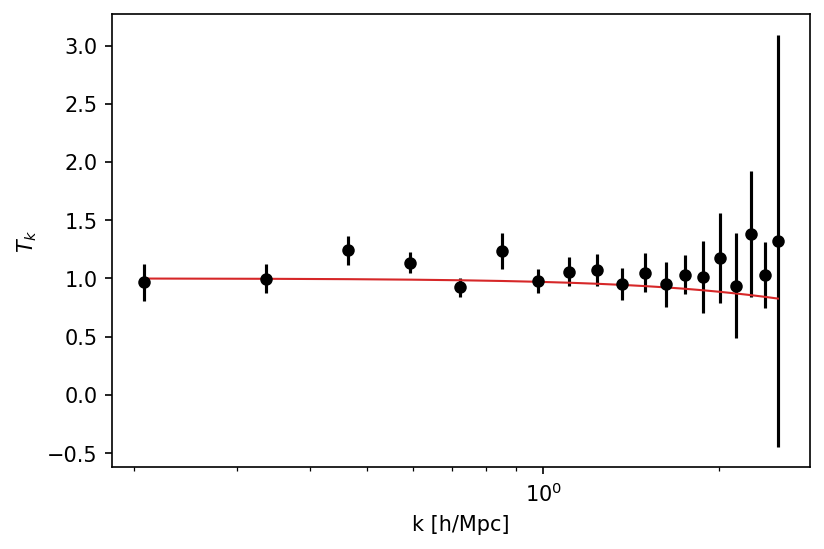

In [88]:
data.plot_Tk()
idm_model.plot_Tk()

### Posterior Sampling

In [89]:
posterior = Sampler(data, idm_model, 
                    param_names=["log_sigma_dmeff",], 
                    guess=[-29,],
                    param_limits=[[-30,-28],],
                    n_walkers=2,
                    n_steps=500,
                   )

# ---------------------------------------------------------

# to sample mass simply add it to the parameters like this:

# posterior = Sampler(data, idm_model, 
#                     param_names=["log_sigma_dmeff", "log_m_dmeff"], 
#                     guess=[-29, -4],
#                     param_limits=[[-30,-28], [-5,-3]],
#                     n_walkers=2,
#                     n_steps=50,
#                    )

# ---------------------------------------------------------

In [79]:
posterior.sample(find_lkl_min=False)

initializing the sampler...


100%|██████████| 500/500 [11:51<00:00,  1.42s/it]


### Plots

In [82]:
samples= posterior.samples.reshape(-1)

In [83]:
kde = gaussian_kde(samples)
x = np.linspace(-30,-28,100)

pdf = kde.pdf(x)

Text(0, 0.5, 'Posterior probability ')

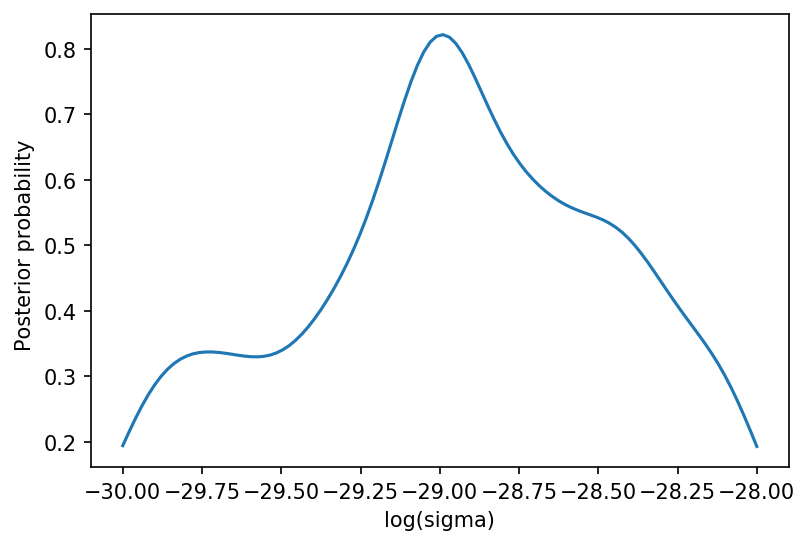

In [84]:
plt.plot(x, pdf)
plt.xlabel("log(sigma)")
plt.ylabel("Posterior probability ")